In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Import my modules
sys.path.append('../modules') # Path to modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg
from preprocess_dataframes import combine_ivt_ar_prec_df, df_annual_clim, calculate_ivt_prec_percentiles, df_AR_annual_clim, df_AR_precip_contribution

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs
prec_clim, prec_std = df_annual_clim(df_lst, community_lst, varname='prec') # get precipitation annual climatology
ivt_clim, ivt_std = df_annual_clim(df_lst, community_lst, varname='IVT') # get IVT annual climatology

prec_percentile, ivt_percentile = calculate_ivt_prec_percentiles(df_lst, community_lst) # get dataframe of percentiles

# some cleaning for the dfs for the annual clim fig
prec_clim['month'] = prec_clim.index.values - 1
prec_melt = pd.melt(prec_clim, id_vars='month')

ivt_clim['month'] = ivt_clim.index.values - 1
ivt_melt = pd.melt(ivt_clim, id_vars='month')

ar_clim = df_AR_annual_clim(df_lst, community_lst, varname='AR') # get AR annual climatology

cross_tab = df_AR_precip_contribution(df_lst, community_lst, varname='prec') # contribution to annual precip

In [5]:
prec_clim

,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan,month
time,,,,,,,
1,171.31,155.90,114.69,275.67,183.47,180.99,0
2,112.46,115.82,74.69,205.50,123.02,124.29,1
3,118.68,108.13,72.16,184.61,135.98,147.87,2
4,91.94,79.70,50.20,152.17,121.69,130.61,3
5,81.36,65.36,43.68,151.90,77.49,83.92,4
6,70.51,45.02,32.89,95.92,65.66,72.33,5
7,101.90,50.58,37.94,154.31,71.47,71.47,6
8,123.82,91.59,65.52,275.30,103.00,93.69,7
9,203.22,174.44,123.19,369.97,164.97,135.69,8


<AxesSubplot:>

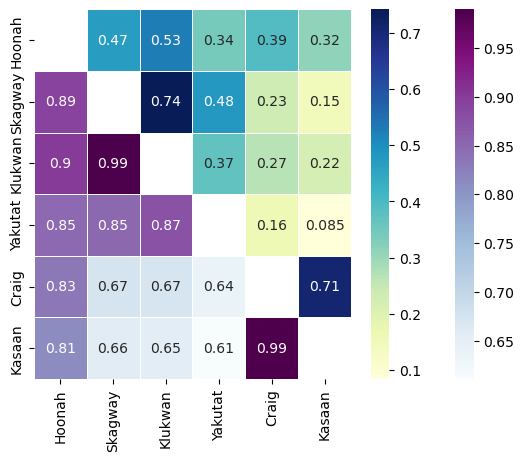

In [4]:
## create correlation table
ivt_corr = ivt_percentile.corr('pearson')
prec_corr = prec_percentile.corr('pearson')

matrix_0 = np.triu(ivt_corr)
matrix_1 = np.tril(prec_corr)

sns.heatmap(ivt_corr,annot=True,mask=matrix_0,cmap="BuPu", linewidth=.5, xticklabels=community_lst, yticklabels=community_lst)
sns.heatmap(prec_corr,annot=True,mask=matrix_1,cmap="YlGnBu", linewidth=.5, xticklabels=community_lst, yticklabels=community_lst)

<AxesSubplot:xlabel='time'>

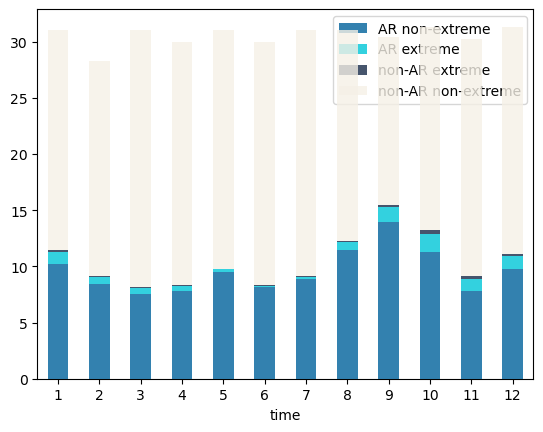

In [6]:
ar_clim.plot(kind = 'bar', stacked = True, color=[ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy'], ucsd_colors['sand']], 
             alpha=0.8, zorder=10, rot='horizontal', legend=True, linewidth=0.)

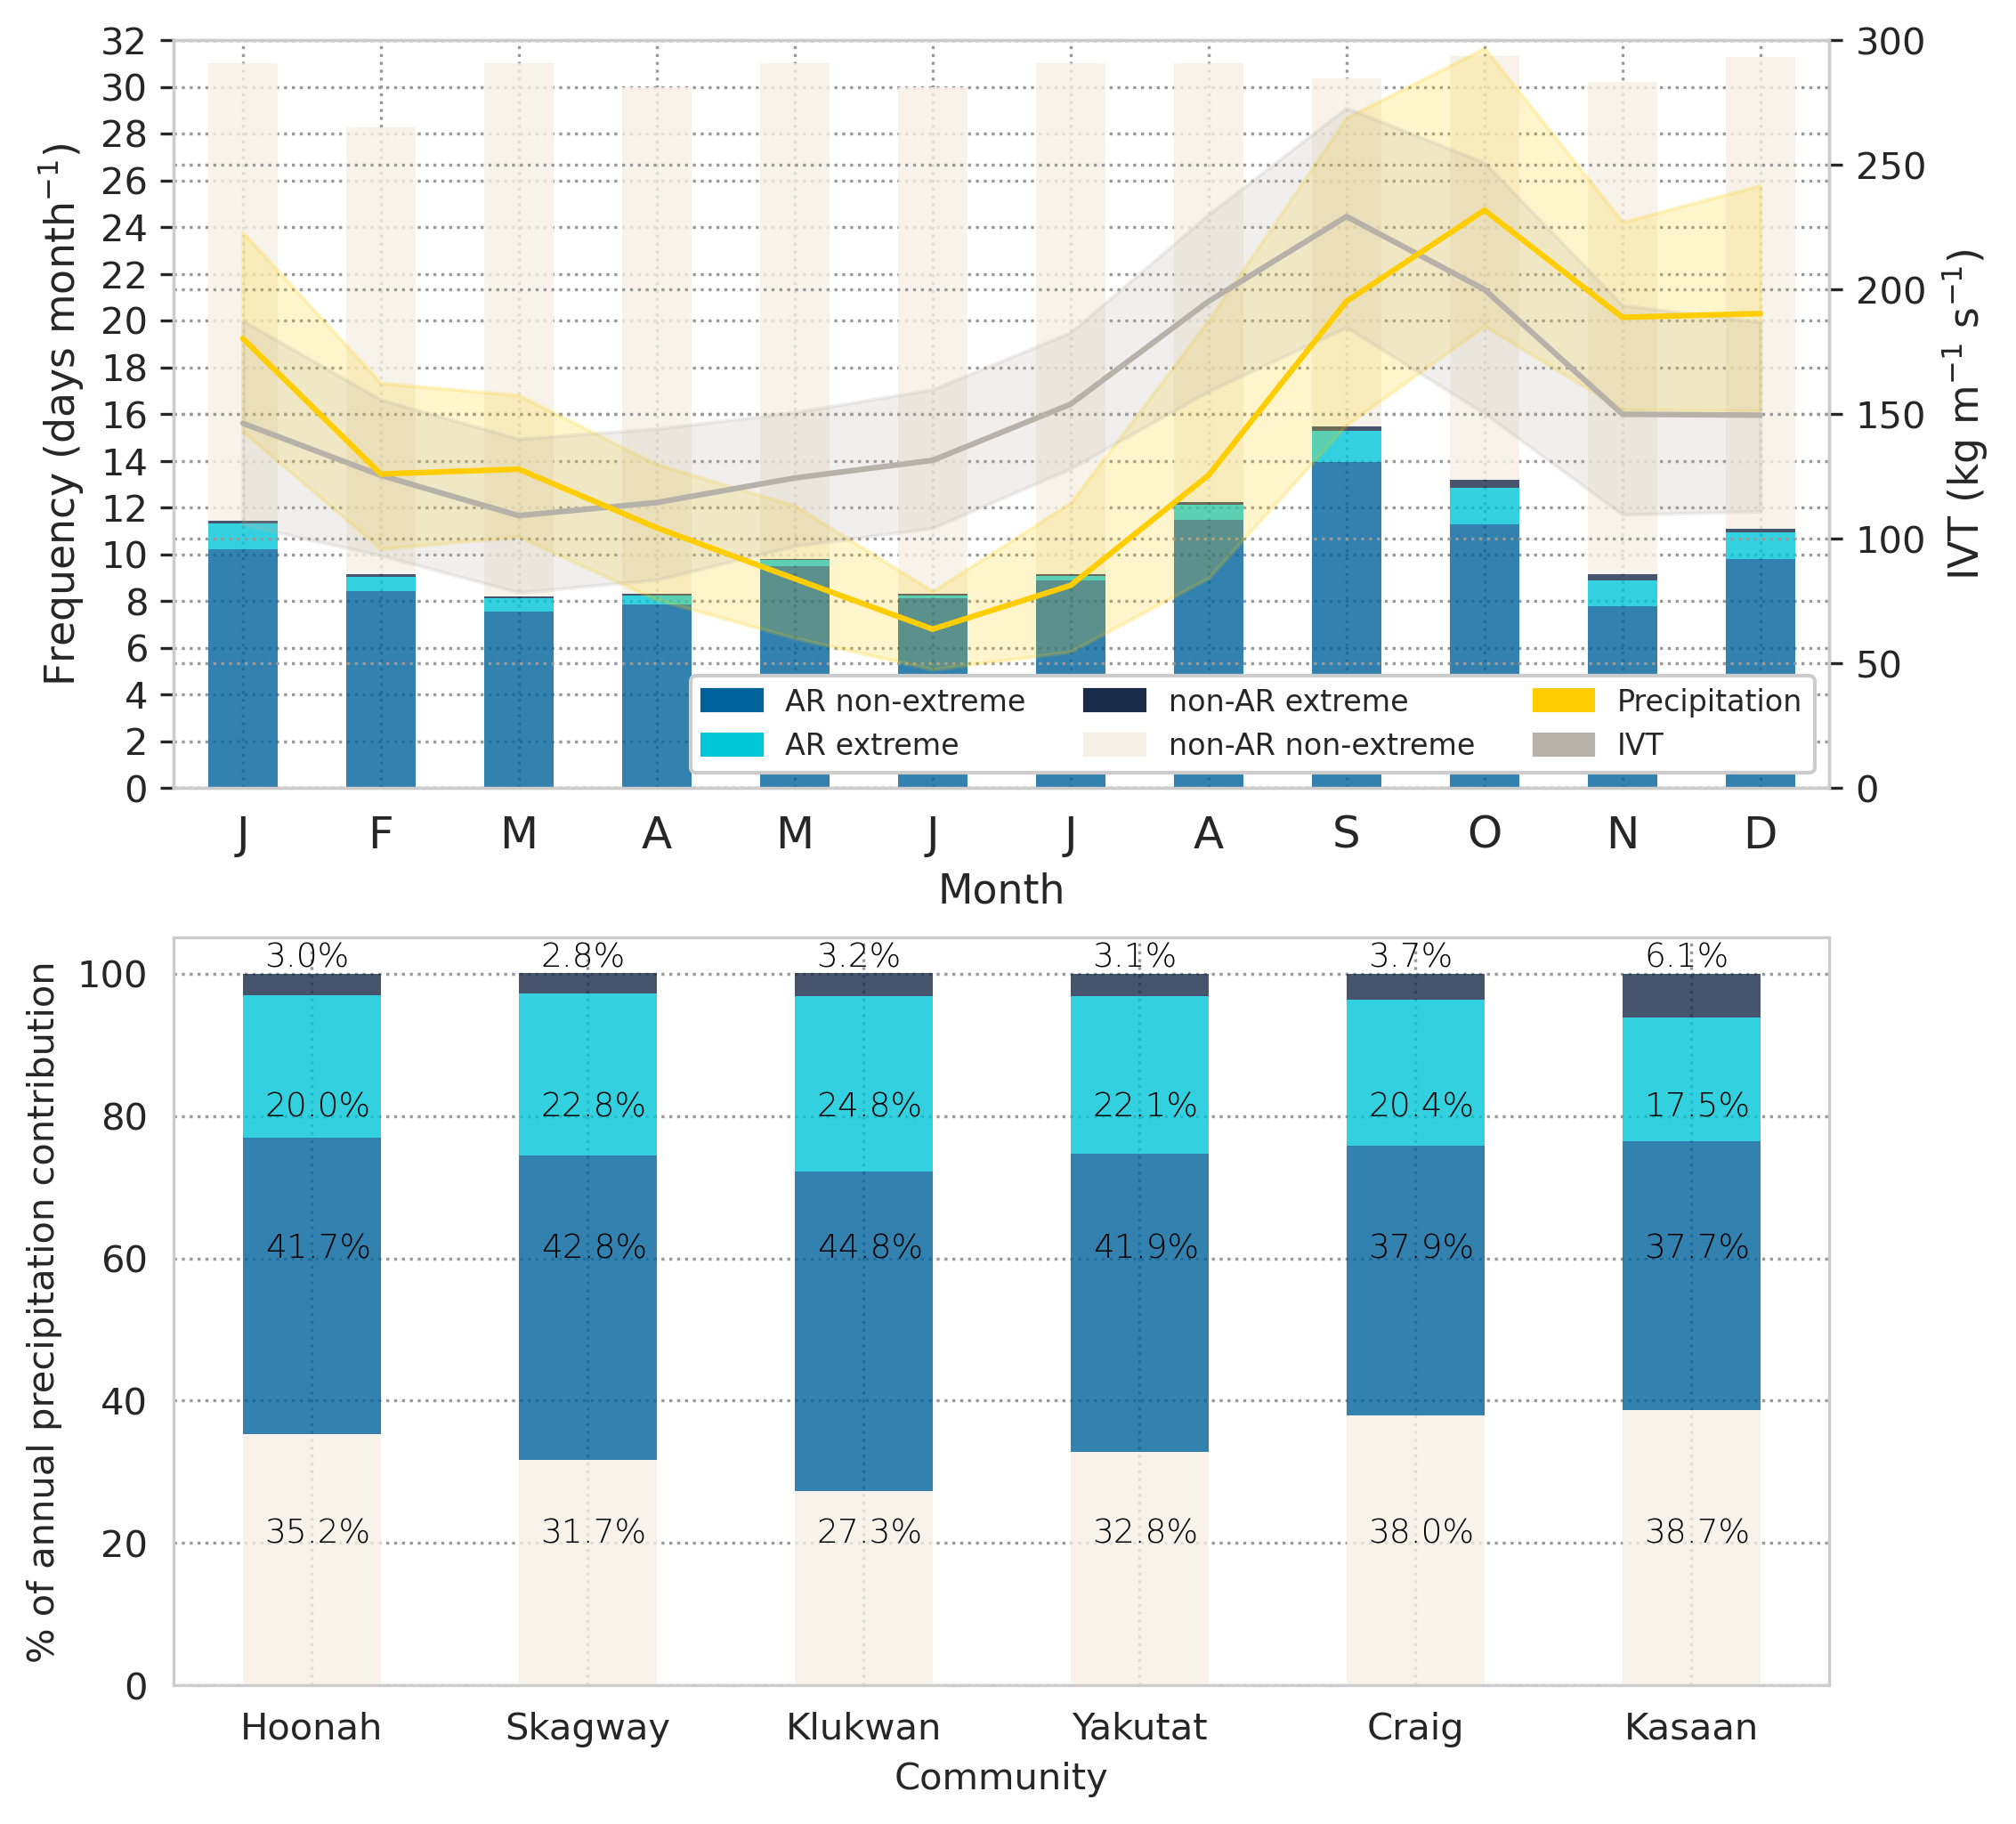

In [9]:
fname = path_to_figs + 'ar_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.0,8.0))
fig.dpi = 300

# Set custom color palette
colors = ["#00629B"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
# sns.set_context("paper")
sns.despine()


ax = fig.add_subplot(2, 1, 1)
## bar plot with AR clim
g = ar_clim.plot(kind = 'bar', stacked = True, color=[ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy'], ucsd_colors['sand']], 
             alpha=0.8, zorder=10, ax=ax, rot='horizontal', legend=False, linewidth=0.)
ax.set_ylabel('Frequency (days month$^{-1}$)', fontsize=11)
ax.set_xlabel('Month', fontsize=11)
ax.set_xticklabels(columns, fontsize=12)
ax.set_yticks(np.arange(0, 36, 4))
ax.set_ylim(0, 32)

# # Add secondary ylabel to first axis
# ax.text(-0.09, 0.5, 'Precipitation (mm day$^{-1}$)', va='bottom', ha='center', 
#         rotation='vertical', rotation_mode='anchor', fontsize=11, 
#         transform=ax.transAxes)

plt.legend([],[], frameon=False)

## add twin axis for ivt
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

## line plot with precip clim
prec = sns.lineplot(data=prec_melt, x="month", y="value", ax=ax2, color=ucsd_colors['yellow'], zorder=101) # plots community spread
## line plot with ivt clim
ivt = sns.lineplot(data=ivt_melt, x="month", y="value", ax=ax2, color=ucsd_colors['stone'], zorder=100) # plots community spread
ax2.set_yticks(np.arange(0, 325, 50))
ax2.set_ylim(0, 300)
ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)

# create legend (of the 3 classes)
patch0 = mpatches.Patch(color=ucsd_colors['blue'], label='AR non-extreme')
patch1 = mpatches.Patch(color=ucsd_colors['aqua'], label='AR extreme')
patch2 = mpatches.Patch(color=ucsd_colors['navy'], label='non-AR extreme')
patch3 = mpatches.Patch(color=ucsd_colors['sand'], label='non-AR non-extreme')
patch4 = mpatches.Patch(color=ucsd_colors['yellow'], label='Precipitation')
patch5 = mpatches.Patch(color=ucsd_colors['stone'], label='IVT')
ax2.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], loc='lower right', framealpha=1.0, ncol=3, fontsize=8).set_zorder(200)

    
### Second row plot
ax3 = fig.add_subplot(2, 1, 2)
cross_tab.plot(kind = 'bar', stacked = True, color=[ucsd_colors['sand'], ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy']], alpha=0.8,
               rot='horizontal', ax=ax3, linewidth=0.)

# plt.legend(loc="lower right", ncol=2)
plt.xlabel("Community")
plt.ylabel("% of annual precipitation contribution")

yloc_new = np.tile([20, 60, 80, 101], (6, 1))
for n, x in enumerate([*cross_tab.index.values]):
    for i, (proportion, y_loc) in enumerate(zip(cross_tab.loc[x],
                                   cross_tab.loc[x].cumsum())):
  
        plt.text(x=n - 0.17,
                 y=yloc_new[n, i],
                 s=f'{np.round(proportion, 1)}%', 
                 color="black",
                 fontsize=9,
                 fontweight="light")
    
plt.legend([],[], frameon=False)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()

../figs/ar_barplot_pie_chart.png


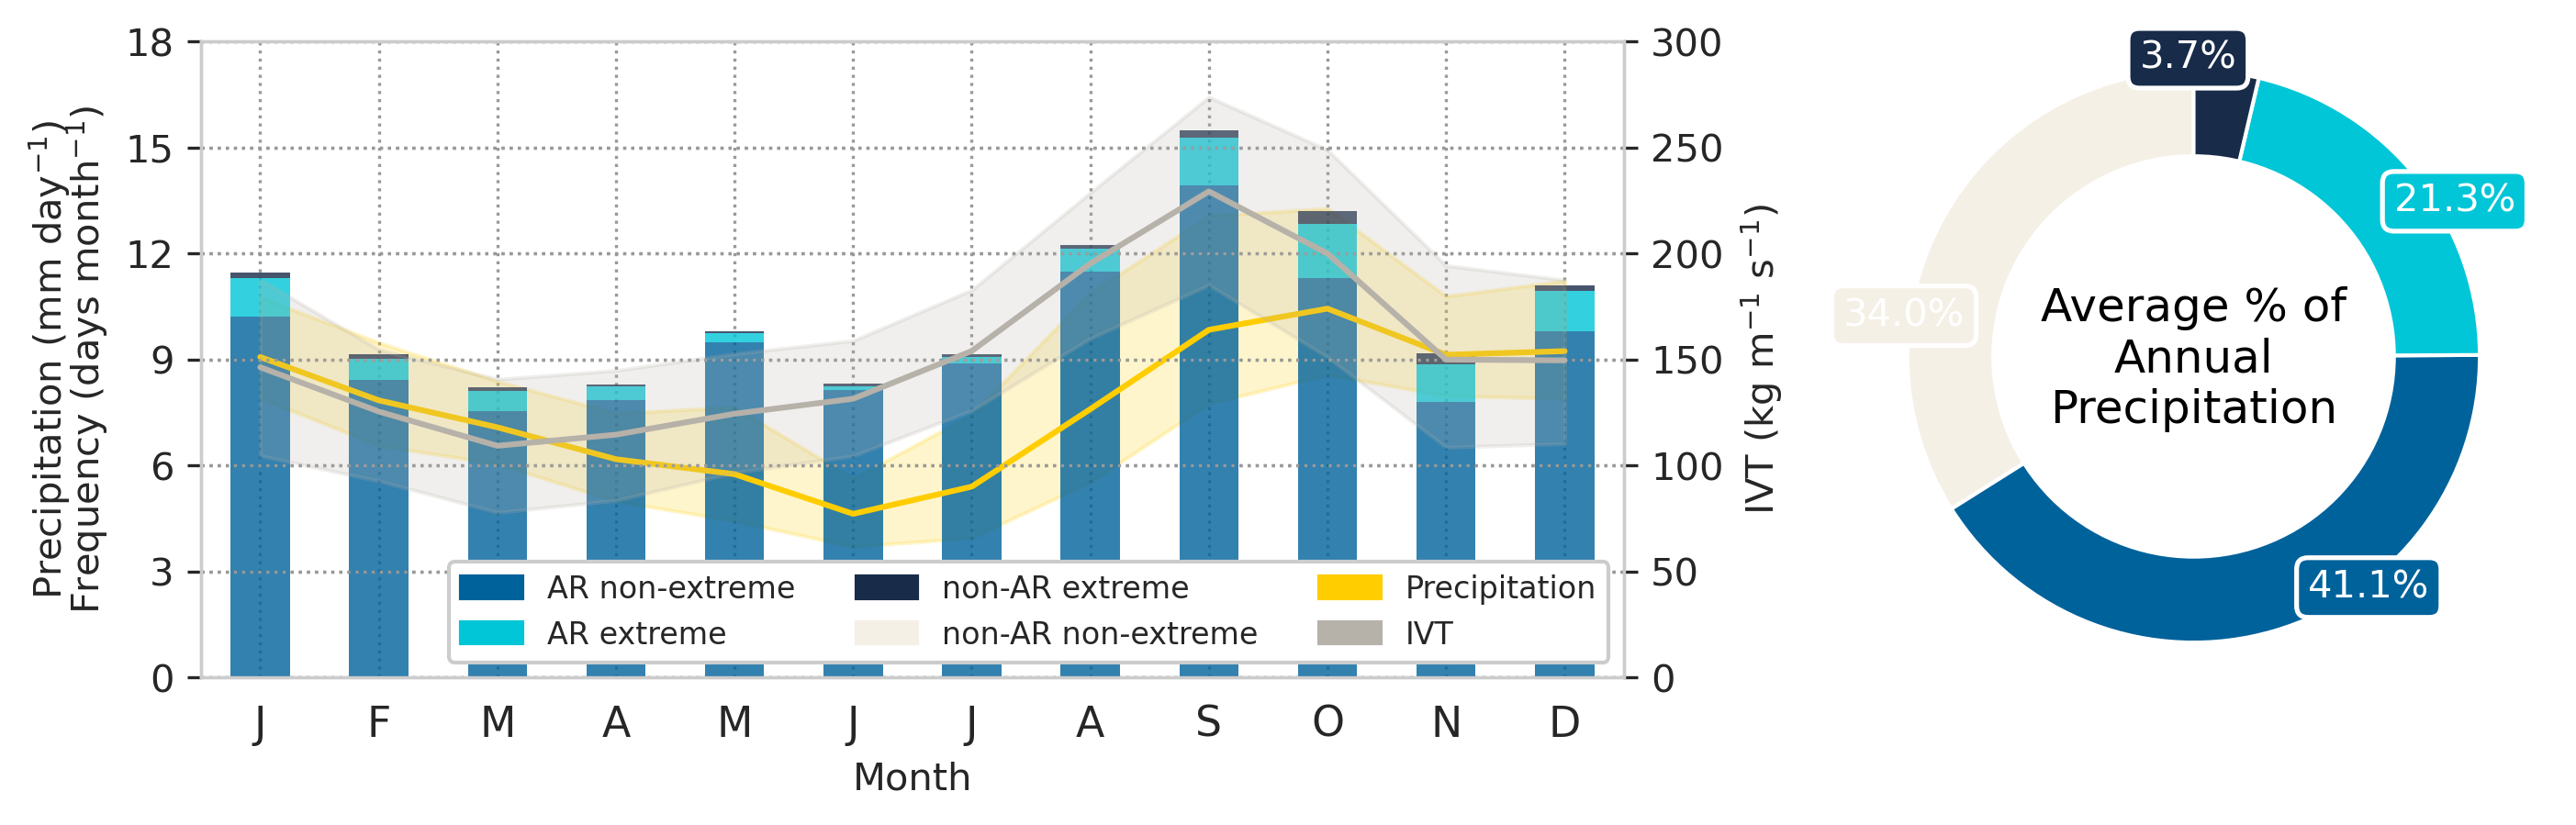

In [23]:
fname = path_to_figs + 'ar_barplot_pie_chart'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((11.0,3.0))
fig.dpi = 300
nrows = 1
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 0.5], wspace=0.2)
## use gs[rows index, columns index] to access grids

###############
## Bar chart ##
###############

# Set custom color palette
colors = ["#00629B"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.despine()

ax = fig.add_subplot(gs[0, 0])
## bar plot with AR clim
ar_clim.plot(kind = 'bar', stacked = True, color=[ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy']], 
                 alpha=0.8, zorder=10, ax=ax, rot='horizontal', legend=False, linewidth=0.)

ax.set_ylabel('Frequency (days month$^{-1}$)', fontsize=10)
ax.set_xlabel('Month', fontsize=10)
ax.set_xticklabels(columns, fontsize=11)
ax.set_yticks(np.arange(0, 21, 3))
ax.set_ylim(0, 18)


## line plot with precip clim
prec = sns.lineplot(data=prec_melt, x="month", y="value", ax=ax, color=ucsd_colors['yellow'], zorder=101) # plots community spread

# Add secondary ylabel to first axis
ax.text(-0.09, 0.5, 'Precipitation (mm day$^{-1}$)', va='bottom', ha='center', 
        rotation='vertical', rotation_mode='anchor', fontsize=10, 
        transform=ax.transAxes)

ax.legend([],[], frameon=False)

## add twin axis for ivt
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ivt = sns.lineplot(data=ivt_melt, x="month", y="value", ax=ax2, color=ucsd_colors['stone'], zorder=100) # plots community spread
ax2.set_yticks(np.arange(0, 325, 50))
ax2.set_ylim(0, 300)
ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10)

# ax.set_axisbelow(True)
# ax2.set_axisbelow(True)

# create legend (of the 3 classes)
patch0 = mpatches.Patch(color=ucsd_colors['blue'], label='AR non-extreme')
patch1 = mpatches.Patch(color=ucsd_colors['aqua'], label='AR extreme')
patch2 = mpatches.Patch(color=ucsd_colors['navy'], label='non-AR extreme')
patch3 = mpatches.Patch(color=ucsd_colors['sand'], label='non-AR non-extreme')
patch4 = mpatches.Patch(color=ucsd_colors['yellow'], label='Precipitation')
patch5 = mpatches.Patch(color=ucsd_colors['stone'], label='IVT')
ax2.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], loc='lower right', framealpha=1.0, ncol=3, fontsize=8).set_zorder(200)

xs = [-0.8, 0.4, 0.7, 0.15] # x points of the label
ys = [0, -0.95, 0.4, 0.9] # y points of the label
lbl_align = ['right', 'left', 'left', 'right'] # where the labels go

###############
## Pie chart ##
###############
plt_title = 'Average % of Annual Precipitation'
vals = cross_tab.mean().values
labels = []
for n, x in enumerate(vals):
    labels.append(f'{np.round(x, 1)}%')
colors = [ucsd_colors['sand'], ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy']]
 
ax = fig.add_subplot(gs[0, 1])
ax.pie(vals, colors = colors, autopct=None, startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax.add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
ax.annotate(textwrap.fill(plt_title, 13), # this is the text
               (0,-0.3), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,5), # distance from text to points (x,y)
                ha='center', # horizontal alignment can be left, right or center
                xycoords='data',
                zorder=102,
                fontsize=12,
                color='k')

## Plot the labels
# zip joins x and y coordinates in pairs
for x,y,z,ha,face in zip(xs,ys, labels, lbl_align,colors):

    ax.annotate(z, # this is the text
               (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,8), # distance from text to points (x,y)
                ha=ha, # horizontal alignment can be left, right or center
                bbox=dict(boxstyle="round,pad=0.3", fc=face, ec="white", lw=1.25, alpha=1.),
                xycoords='data',
                zorder=102,
                fontsize=10,
                color="white")


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=300)

plotFile = fname + '.png'
print(plotFile)

In [26]:
final_df_lst = []
## some information on AR contribution
for i, df_tmp in enumerate(df_lst):
    prec_thres = df_tmp['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    
    summary_df = pd.DataFrame(columns=['# prec days', '# AR days (non-extreme)', '# extreme prec days','# extreme AR days',
                                       'total annual prec', 'total AR prec (non-extreme)', 'total extreme prec', 'total extreme AR prec'], index=range(1980, 2020))
    
    for j, yr in enumerate(range(1980, 2020)):
        idx = (df_tmp.index.year == yr)
        df = df_tmp.loc[idx]
        # number of days per year with precipitation > 0.1
        total_count = df.shape[0]
        calm_count = df.query("prec < 0.1").shape[0]
        x = (total_count - calm_count) # number of days with precipitation greater than 0.1 mm per day
        
        # number of AR days per year
        idx = (df.AR == 1) & (df.prec > 0.1) & (df.prec < prec_thres)
        ar_days = len(df.loc[idx]) # number of AR days per year
        ar_prec_clim = df.loc[idx].prec.sum() # get total precipitation per year during non-extreme ARs
    
        # AR contribution to total annual precipitation
        ## (total annual precip during AR days / total annual precip) * 100
        prec_clim = df.prec.sum() # get total precipitation per year
        
        # number of days per year where precipitation is "extreme" > 95th percentile
        extreme_count = df.query("prec > {0}".format(prec_thres)).shape[0]
    
        ## number of AR days with extreme precipitation
        idx = (df.AR == 1) & (df.prec > prec_thres)
        ar_days_extreme  = len(df.loc[idx]) # days
        ar_prec_clim_extreme = df.loc[idx].prec.sum() # amount of precip
    
        ## AR contribution to extreme precipitation
        ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
        extreme_prec_clim = df.loc[(df.prec > prec_thres)].prec.sum()
        ar_contr_extreme = (ar_prec_clim_extreme / extreme_prec_clim) *100
        
        summary_df.loc[yr] = pd.Series({'# prec days': x,
                                        '# AR days (non-extreme)': ar_days,
                                        '# extreme prec days': extreme_count,
                                        '# extreme AR days': ar_days_extreme,
                                        'total annual prec': prec_clim,
                                        'total AR prec (non-extreme)': ar_prec_clim,
                                        'total extreme prec': extreme_prec_clim, 
                                        'total extreme AR prec': ar_prec_clim_extreme})
        
        summary = summary_df.mean() # average all years
    final_df_lst.append(summary)
    

df_concat = pd.concat(final_df_lst)

In [ ]:
## some information on AR contribution
for i, df in enumerate(df_lst):
    print('On average in {0}...'.format(community_lst[i]))
    # number of days per year with precipitation > 0.1
    total_count = df.shape[0]
    calm_count = df.query("prec < 0.1").shape[0]
    # print('Of {} total observations, {} have less than 0.1 mm of precipitation.'.format(total_count, calm_count))
    x = (total_count - calm_count) / 40.
    print('...there are {0} days per year with precipitation greater than 0.1 mm per day'.format(x))
    # number of AR days per year
    idx = (df.AR == 1) & (df.prec > 0.1)
    tmp = df.loc[idx]
    ar_days = len(tmp) / 40.
    print('...there are {0} AR days per year'.format(ar_days))
    
    # AR contribution to total annual precipitation
    ## (total annual precip during AR days / total annual precip) * 100
    prec_clim = df.prec.groupby(df.index.year).sum() # get total precipitation per year
    ar_prec_clim = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during ARs
    ar_contr = (ar_prec_clim / prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to total annual precipitation'.format(avg_ar_contr))
    
    # number of days per year where precipitation is "extreme" > 95th percentile
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    extreme_count = df.query("prec > {0}".format(prec_thres)).shape[0]
    x = extreme_count / 40.
    print(u'...there are {:.2f} days per year with precipitation greater than {:.2f} mm per day'.format(x, prec_thres))
    
    ## number of AR days with extreme precipitation
    idx = (df.AR == 1) & (df.prec > prec_thres)
    tmp = df.loc[idx]
    ar_days_extreme = len(tmp) / 40.
    print('...{0} of which are AR days'.format(ar_days_extreme))
    
    ## AR contribution to extreme precipitation
    ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
    extreme_prec = df.loc[(df.prec > prec_thres)]
    extreme_prec_clim = extreme_prec.prec.groupby(extreme_prec.index.year).sum() # get total precipitation during extreme events
    ar_prec_clim_extreme = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during extreme ARs
    ar_contr = (ar_prec_clim_extreme / extreme_prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to extreme precipitation'.format(avg_ar_contr))
    
    # number of impact days that are also ARs
    a = len(df.loc[(df['impact'] == 1)])
    b = len(df.loc[(df['impact'] == 1) & (df['AR'] == 1) ])
    print('...Out of the {0} days indicated as an impact day, {1} of them were associated with an AR'.format(a, b))

In [ ]:
## getting bins for windrose based on percentiles
perc = [0., 0.10, 0.25, 0.5, 0.75, .95, 1.]
perc_lbl = ['0%', '10%', '25%', '50%', '75%', '95%', '100%']
prec_thres_lst = []
ivt_thres_lst = []
for i, df in enumerate(df_lst):
    sublist = []
    sublist_ivt = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
        sublist_ivt.append(df['IVT'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    flat_list_ivt = [item for l in sublist_ivt for item in l] # flatten the list
    prec_thres_lst.append(flat_list)
    ivt_thres_lst.append(flat_list_ivt)

In [ ]:
# 95th percentile threshold for precipitation and IVT for ALL days
prec_thres = []
ivt_thres = []
for i, df in enumerate(df_lst):
    prec_thres.append(df['prec'].describe(percentiles=[.95]))
    ivt_thres.append(df['IVT'].describe(percentiles=[.95]))
    
    df['IVT'].describe(percentiles=[.95]).loc['95%']
    
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 1)]))
    non_ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 1)]))
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

### Plot IVT/Precip Scatter and IVT direction and precipitation in windrose
Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [ ]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('<{}'.format(right))
        elif right == bins[-1]:
            labels.append('>{}'.format(left))
        else:
            labels.append('{}-{}'.format(str(left[:-1]), right))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)
        
    # xticks = ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.1), ncol=1, fontsize=12, title='Percentile')
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    # if temporal_res == 'hourly':
    #     calm_thres = 0.1
    # if temporal_res == 'daily':
    #     calm_thres = 2
    calm_thres = prec_bins[0]
    calm_count = df.query("prec < {0}".format(calm_thres)).shape[1]
    print('Of {} total observations, {} have less than {} mm of precipitation.'.format(total_count, calm_count, calm_thres))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          # .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

In [ ]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
colors = [ucsd_colors['navy'], ucsd_colors['aqua'], ucsd_colors['yellow'], ucsd_colors['grey']]
legend_lst = [True] + [False]*5
# legend_lst = [True]*6

fname = path_to_figs + 'IVT-prec_scatter_{0}'.format(temporal_res)
fmt = 'png'
nrows = 2
ncols = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(14,10))

sns.set_style("whitegrid")

for i, df in enumerate(df_lst):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ## get 95th percentile of ivt and precip
    ivt_thres = df['IVT'].describe(percentiles=[.95]).loc['95%']
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%']
    
    # plot non-AR cases
    data = df.loc[(df.AR == 0)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[0]]), label='non-AR days'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[1]]), label='AR days'.format(n), alpha=0.2, legend=legend_lst[i])
    
    
    
    print('IVT thres: {:,.2f}'.format(ivt_thres), 'Prec thres: {:,.2f}'.format(prec_thres))
    
    plt.axhline(y=prec_thres, color='tab:red', linestyle='-')
    plt.axvline(x=ivt_thres, color='tab:red', linestyle='-')
    
    ## plot Extreme AR days
    data = df.loc[(df['impact'] == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[2]]), label='impact days'.format(n), alpha=0.5, legend=legend_lst[i])
    
#     ## plot Extreme non-AR days
#     data = df.loc[(df['prec'] > prec_thres) & (df.AR == 0)]
#     n = len(data)
#     g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[3]]), label='Extreme non-AR days (n={0})'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    if temporal_res == 'hourly':
        ax.set_ylim(-.5, 25)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        ax.set_ylim(-10, 150)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
        
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')
    # ax.set_title('(n={0})'.format(n), loc='right')
    
    ax.set_ylabel(y_lbl)
    
    if legend_lst == True:
        leg = ax.legend(loc='upper left', ncol=1)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

In [ ]:
def assign_percentiles(df, prec_bins, ivt_bins, perc_labels):
    '''
    ### Determine the percentile group for precipitation and ivt

    - assign a precipitation bin for each row with pandas.cut
    - assign a ivt bin for each row with pandas.cut
    '''
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=perc_labels, right=True))
            .assign(ivt_bins=lambda df: pd.cut(df['IVT'], bins=ivt_bins, labels=perc_labels, right=True))
         )
    
    df = df.rename(columns={"prec_bins": "Precipitation Percentiles", "ivt_bins": "IVT Percentiles"})
        
    return df

def community_heatmap_values(df, perc_lbl):
    denom = np.empty((6, 6), float)
    num = np.empty((6, 6), float)
    extreme_prec_AR = np.empty((6), float)
    extreme_ivt_AR = np.empty((6), float)
    for i, perc_i in enumerate(perc_lbl):
        ## get total number of precipitation days within each percentile bin
        idx = (df['Precipitation Percentiles'] == perc_i)
        denom_val = len(df.loc[idx])
        

        ## get total number of IVT days within the same percentile bin
        
        for j, perc_j in enumerate(perc_lbl):
            idx = (df['Precipitation Percentiles'] == perc_i) & (df['IVT Percentiles'] == perc_j)
            num_val = len(df.loc[idx])
            num[j, i] = num_val # put numerator in array
            
            # put denominator in array
            denom[j, i] = denom_val # put denominator in array
            
            
        ## get fraction of AR days that are also 95th percentile precip
        idx = (df['Precipitation Percentiles'] == perc_i) & (df['AR'] == 1)
        AR_num = len(df.loc[idx])
        extreme_prec_AR[i] = (AR_num/denom_val)*100

        ## get fraction of AR days that are also 95th percentile IVT
        idx = (df['IVT Percentiles'] == perc_i)
        denom_val = len(df.loc[idx])
        idx = (df['IVT Percentiles'] == perc_i) & (df['AR'] == 1)
        AR_num = len(df.loc[idx])
        extreme_ivt_AR[i] = (AR_num/denom_val)*100
        
    heatmap_vals = (num/denom)*100
    
    return heatmap_vals, extreme_prec_AR, extreme_ivt_AR


def create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, axhistx, axhisty, tck_lblx, tck_lbly, bar_tck):

    # no labels, remove spines
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.set_ylim(0, 99)

    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.set_ylim(0, 99)
    
    ax_histx.bar(x = bar_tck, height=extreme_prec_AR, align='edge', color='#DAE6E6')
    ax_histy.barh(range(len(bar_tck)), np.flip(extreme_ivt_AR), align='edge', color='#DAE6E6')
    
    ## add heatmap
    g = sns.heatmap(np.flipud(heatmap_vals), cmap=cmo.dense, annot=True, linewidth=.5, xticklabels=tck_lblx, yticklabels=tck_lbly, ax=ax, cbar=False)
    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=8, 
                   length=4, 
                   pad=2, 
                   color='black',
                   labelrotation=0.0)
    
    

    

## Create panel plot of percentile histogram plots

In [ ]:
np.flip(range_labels(perc_lbl))

In [ ]:
fname = path_to_figs + 'percentile_bins_{0}'.format(temporal_res)
fmt = 'png'

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# Start with a square Figure. - then multiple each by the number of rows and columns you want of each full panel
nrows = 2
ncols = 3
# lists of axes locations - I couldn't math this out, but this works
ax_lst = [[1, 0], [1, 2], [1, 4], [3, 0], [3, 2], [3, 4]]
axhistx_lst = [[0, 0], [0, 2], [0, 4], [2, 0], [2, 2], [2, 4]]
axhisty_lst = [[1, 1], [1, 3], [1, 5], [3, 1], [3, 3], [3, 5]]

tcklblx_lst = [False, False, False, range_labels(perc_lbl), range_labels(perc_lbl), range_labels(perc_lbl)]
tcklbly_lst = [np.flip(range_labels(perc_lbl)), False, False, np.flip(range_labels(perc_lbl)), False, False]

xlbl_lst = ['']*3 + ['Precipitation']*3
ylbl_lst = ['IVT', '', '']*2

sns.set_theme(style="ticks")

fig = plt.figure(figsize=(6*ncols, 6*nrows))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2*nrows, 2*ncols,  width_ratios=[4, 1]*ncols, height_ratios=[1, 4]*nrows,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


for i, df in enumerate(df_lst):
    # get percentile values
    perc_prec = prec_thres_lst[i]
    perc_ivt = ivt_thres_lst[i]
    # giving each df a column for percentile bins for precip and ivt
    tmp = assign_percentiles(df, prec_thres_lst[i], ivt_thres_lst[i], range_labels(perc_lbl))
    heatmap_vals, extreme_prec_AR, extreme_ivt_AR = community_heatmap_values(tmp, range_labels(perc_lbl))
    print(extreme_prec_AR, extreme_ivt_AR)
    
    # Create the Axes.
    ax = fig.add_subplot(gs[ax_lst[i][0], ax_lst[i][1]])
    ax_histx = fig.add_subplot(gs[axhistx_lst[i][0], axhistx_lst[i][1]], sharex=ax)
    ax_histy = fig.add_subplot(gs[axhisty_lst[i][0], axhisty_lst[i][1]], sharey=ax)
    
    # plot the heatmap and marginal bar charts
    create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, ax_histx, ax_histy, tcklblx_lst[i], tcklbly_lst[i], range_labels(perc_lbl))
    ax.set_xlabel(xlbl_lst[i])
    ax.set_ylabel(ylbl_lst[i])
    
    # plot title
    titlestring = '({0}) {1}'.format(letter_lst[i], community_lst[i])
    ax_histx.text(0.025, 1.27, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    
    ax_histy.invert_yaxis()
    ax.invert_yaxis()
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)